In [1]:
import vcf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import refgene_parser
from pybedtools import BedTool
import pyfaidx
import csv
from collections import Counter

from IPython.display import clear_output

In [83]:
gnomAD_path  = "/home/sacha/Download/gnomad.genomes.r2.0.2.sites.chr20.vcf"
hg19_path    = "/home/sacha/Linux_data/bioinfo/data/ucsc/hg19.fa"
refGene_path = "/home/sacha/Linux_data/bioinfo/data/ucsc/hg19.farefGene.txt.gz"
bed_path     = "/home/sacha/Linux_data/bioinfo/data/gnomAd_3mer.bed"
hg19         = pyfaidx.Fasta(hg19_path)

## Function pour extraire le 3-mer encadrant un snps : ex: NpCpN

In [84]:
def triplet(chrom,pos, margin = 1):
        try:
            region = hg19.get_seq(chrom,pos-margin, pos+margin)
            return region.seq
        except:
            return 'NNN'

## Parcours du VCF gnomAD pour récupérer uniquement les Snps

In [ ]:
bedfile    = open(bed_path, 'w')
csvwriter  = csv.writer(bedfile,delimiter="\t")
total      = hg19.records["chr20"].unpadded_len

vcf_reader = vcf.Reader(open(gnomAD_path, 'r'))   
for record in vcf_reader:
    
    if record.is_snp:
        chrom       = "chr"+record.CHROM
        kmer        = triplet(chrom,record.POS,1)
        # vcf to bed is 1-based to 0-based
        kmer_alt    = kmer[0] + str(record.ALT[0]) + kmer[2]
        output      = [chrom, record.POS -2 , record.POS, kmer.upper(), kmer_alt.upper(),record.INFO['AF'][0]]
        csvwriter.writerow(output)     
        
        clear_output(wait=True)
        print("progress {0:10.4f}%".format(record.POS / total * 100), end="")
        
        
    

bedfile.close()

progress    25.3353%

### Reverse complement

In [2]:
def reverse_complement(dna):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join([complement[base] for base in dna[::-1]])

## Analyse du fichier bed 

In [3]:
bed_path = "/data/Downloads/gnomAd_3mer.bed"
bed = BedTool(bed_path)
df  = bed.to_dataframe()
df.columns = ["chrom", "start","end", "ref", "alt", "af"]

In [18]:
olddf = df 

In [31]:
''' Standardize kmer '''
mask = (df.ref.str.get(1) == 'A') | (df.ref.str.get(1) == 'G')
# Split 
a  = df[~mask].copy()
b  = df[mask].copy()

b.ref = b.ref.apply(reverse_complement)
b.alt = b.alt.apply(reverse_complement)

alldf = pd.concat([a,b])



In [39]:
alldf["mut"] = alldf.ref.str.get(1) + ">" + alldf.alt.str.get(1)

In [40]:
alldf.head()

,chrom,start,end,ref,alt,af,mut
4,chr20,60119,60121,ACA,ATA,0.000033,C>T
5,chr20,60128,60130,CCA,CAA,0.000033,C>A
10,chr20,60284,60286,ATA,ACA,0.000032,T>C
12,chr20,60290,60292,GCC,GTC,0.000032,C>T
14,chr20,60312,60314,TCC,TTC,0.000097,C>T


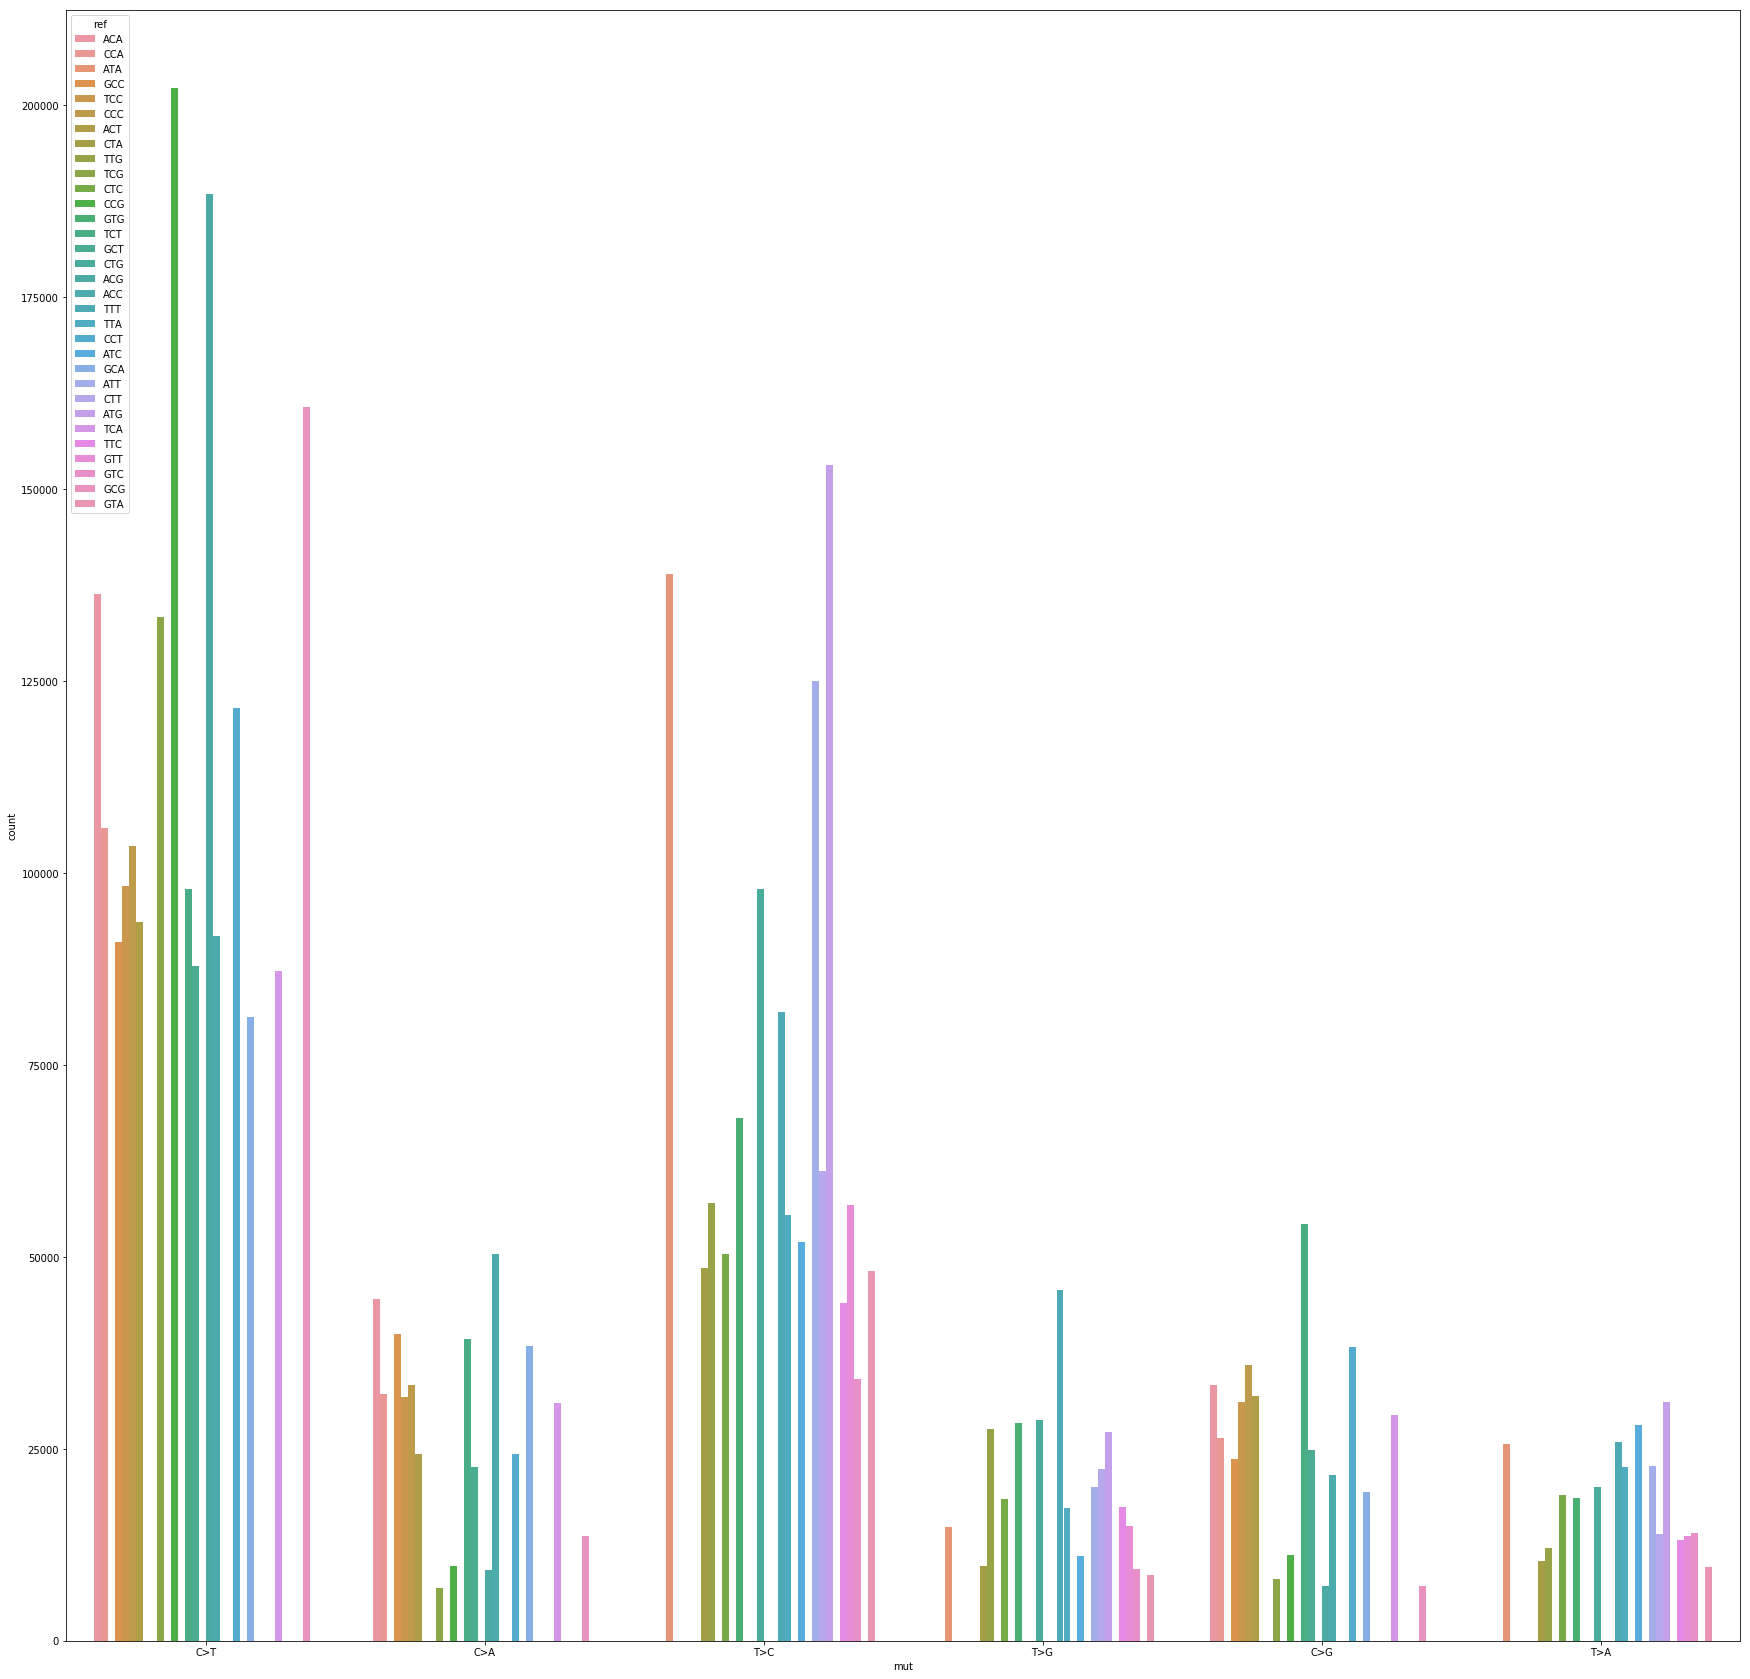

In [56]:
plt.figure(figsize=(30,30))
sns.countplot(x="mut", hue="ref",data= alldf)

plt.savefig("plot.png")


In [4]:
counter = Counter()

for rec in bed:
    ref = rec[3]
    alt = rec[4]
    if ref[1] in ('A','G'):
        ref = reverse_complement(ref)
        alt = reverse_complement(alt)
        
    counter[(ref,alt)] += 1
    
    



In [34]:
df.head()

,chrom,start,end,ref,alt,af
0,chr20,60014,60016,AGA,AAA,0.000034
1,chr20,60036,60038,TAT,TGT,0.000067
2,chr20,60047,60049,TGA,TTA,0.000033
3,chr20,60090,60092,AGG,AAG,0.000033
4,chr20,60119,60121,ACA,ATA,0.000033
